# Классы

In [127]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [128]:
class ZeroCrossingSignal:

    def __init__(self, signal, harmonic_hf, start_offset, start_period):
        self.__amplitudes, self.__phases, self.__biases = self.zero_crossing(signal, harmonic_hf, start_offset, start_period)

    @staticmethod
    @njit
    def zero_crossing(signal, harmonic_hf, start_offset, start_period):
        offset = start_offset
        period = start_period

        amplitudes = [1.,]
        phases = [1.,]
        biases = [1.,]

        amplitudes.pop()
        phases.pop()
        biases.pop()

        harmonics_vector = np.array([0., 0., 0.])
        iteration = 0

        while offset < (len(signal) - np.floor(period)-1):
            phase = 2 * np.pi / period * harmonic_hf # связано со временеи обората, длинна сгустка - bunch ## похоже на фазу 
 
            harmonics_vector[0] = np.sum(signal[offset:offset + int(period) + 1] * np.cos(phase * np.arange(int(period) + 1)))
            harmonics_vector[1] = np.sum(signal[offset:offset + int(period) + 1] * np.sin(phase * np.arange(int(period) + 1)))
            harmonics_vector[2] = np.sum(signal[offset:offset + int(period) + 1])
 
            P_b = np.array(((0., 0., 0.),
                            (0., 0., 0.),
                            (0., 0., 0.)))

            cos_vals = np.cos(phase * np.arange(int(period) + 1))
            sin_vals = np.sin(phase * np.arange(int(period) + 1))

            P_b[0, 0] = np.sum(cos_vals**2)
            P_b[0, 1] = np.sum(cos_vals * sin_vals)
            P_b[0, 2] = np.sum(cos_vals)
            P_b[1, 0] = P_b[0, 1]
            P_b[1, 1] = np.sum(sin_vals**2)
            P_b[1, 2] = np.sum(sin_vals)
            P_b[2, 0] = P_b[0, 2]
            P_b[2, 1] = P_b[1, 2]
            P_b[2, 2] = int(period) + 1

            A = np.linalg.inv(P_b) @ harmonics_vector.T # ----
     
            amplitudes.append(np.sqrt(A[0]**2 + A[1]**2)) # амплитуда 
            phases.append(offset + (1 / phase * np.arctan2(A[0], -A[1]))) # фаза 
            biases.append(A[2]) # ----

            offset = int(phases[iteration] + period) # перечет офсета 

            period = 1 / 10 * (phases[iteration] - phases[iteration-10]) if iteration > 12 else period # перечсет периода для окна 

            iteration += 1

        return np.array(amplitudes), np.array(phases), np.array(biases)
        
    @property
    def amplitudes(self): return self.__amplitudes

    @property
    def phases(self): return self.__phases

    @property
    def biases(self): return self.__biases

In [129]:
class LorentzFactors:
    def __init__(self, phases, booster_perimeter, delta_time, speed_of_light=2.997925e10, proton_rest_mass = 938.256e6):
        self.__phase_difference = np.diff(phases)
        self.__beta = booster_perimeter / (speed_of_light * delta_time * self.phase_difference)
        self.__gamma = 1 / np.sqrt(1 - self.beta**2)
        self.__energy = (self.gamma-1) * proton_rest_mass

    @property
    def phase_difference(self): return self.__phase_difference

    @property
    def beta(self): return self.__beta

    @property
    def gamma(self): return self.__gamma

    @property
    def energy(self): return self.__energy

In [130]:
class AveragedData:
    def __init__(self, phases, corrected_phases, intensities, averaging_window):
        self.__phases = self.average_data(phases, averaging_window)
        self.__corrected_phases = self.average_data(corrected_phases, averaging_window)
        self.__intensities = self.average_data(intensities, averaging_window)
    
    
    @staticmethod
    def average_data(data, averaging_window):
        return np.convolve(data, np.ones(averaging_window)/averaging_window, mode='valid')

In [153]:
class ParametersFCTRF:
    def __init__(self, signal_fct, signal_rf, period, offset_fct, offset_rf, offset_between_signals,
                 harmonic_hf, booster_perimeter, delta_time, averaging_window_for_finding_fct_minimums,
                 averaging_window, phase_offset=0, charge_number = 28, proton_rest_mass = 938.256e6,
                 electron_charge = 1.6021e-19, speed_of_light = 2.997925e10):

        self.__signal_fct = signal_fct
        self.__signal_rf = signal_rf
        self.__period = period
        self.__offset_fct = offset_fct
        self.__offset_rf = offset_rf
        self.__delta_time = delta_time
        self.__offset_between_signals = offset_between_signals

        self.__zero_crossing_rf = ZeroCrossingSignal(signal_rf, harmonic_hf, offset_rf, period)
        self.__phases = self.__zero_crossing_rf.phases
        self.__lorentz_factors = LorentzFactors(self.zero_crossing_rf.phases, booster_perimeter, delta_time, speed_of_light, proton_rest_mass)
        # Зачем скипать 1, а потом и phase_offset?
        self.__discretized_phases = np.floor(self.zero_crossing_rf.phases[1:]).astype(int)
        self.__discretized_phases_with_offset = self.discretized_phases[phase_offset:]
        self.__fct_minimums = self.signal_minimums_with_averaging(signal_fct[offset_between_signals:], self.discretized_phases_with_offset,
                                                                averaging_window_for_finding_fct_minimums)
        self.__corrected_phases = self.correct_phases(signal_fct[offset_between_signals:], self.fct_minimums, self.zero_crossing_rf.phases,
                                                      phase_offset, harmonic_hf)
        # self.__averaged_phases = np.convolve(np.hstack((np.zeros(phase_offset), self.corrected_phases)), #Зачем-то добавляется два нуля...
        #                             np.ones(averaging_window_for_phases)/averaging_window_for_phases,
        #                             mode='valid')[::averaging_window_for_phases][:-1] #Зачем-то откидывается последнее...

        self.__intensities = self.find_intensities(signal_fct[offset_between_signals:], self.fct_minimums, self.discretized_phases_with_offset,
                                        delta_time, charge_number=charge_number, electron_charge=electron_charge)    

        self.__averaged_data = AveragedData(np.hstack((np.zeros(phase_offset), self.phases[phase_offset: -phase_offset])),
                                            np.hstack((np.zeros(phase_offset), self.corrected_phases)),
                                            np.hstack((np.zeros(phase_offset), self.intensities)),
                                            averaging_window)

    @property
    def signal_fct(self): return self.__signal_fct

    @property
    def signal_rf(self): return self.__signal_rf
    
    @property
    def delta_time(self): return self.__delta_time

    @property
    def period(self): return self.__period

    @property
    def phases(self): return self.__phases

    @property
    def zero_crossing_rf(self): return self.__zero_crossing_rf

    @property
    def lorentz_factors(self): return self.__lorentz_factors

    @property
    def discretized_phases(self): return self.__discretized_phases

    @property
    def discretized_phases_with_offset(self): return self.__discretized_phases_with_offset
fct
    @property
    def fct_minimums(self): return self.__fct_minimums

    @property
    def corrected_phases(self): return self.__corrected_phases

    @property
    def averaged_phases(self): return self.__averaged_phases

    @property
    def intensities(self): return self.__intensities

    @property
    def averaged_data(self): return self.__averaged_data

    @staticmethod
    @njit
    def correct_phases(signal, signal_minimums, phases, phase_offset, harmonic_hf):
        discretized_phases = phases[1:].astype('int32')
        corrected_phases = np.zeros(len(discretized_phases) - phase_offset - 1, dtype=float)

        for i in range(len(corrected_phases)):
            up_sum = np.sum((signal[discretized_phases[phase_offset+i]: discretized_phases[phase_offset+i+1]+1] - signal_minimums[i])*\
                            (np.arange(discretized_phases[phase_offset+i+1]-discretized_phases[phase_offset+i]+1) + discretized_phases[phase_offset+i] -\
                               (phases[phase_offset+i+2] + phases[phase_offset+i+1]) / 2))
            under_sum = np.sum(signal[discretized_phases[phase_offset+i]:
                                    discretized_phases[phase_offset+i+1]+1] - signal_minimums[i])
            corrected_phases[i] = 360 * harmonic_hf / (discretized_phases[phase_offset+i+1] - discretized_phases[phase_offset+i]) * (up_sum / under_sum)
        
        return corrected_phases

    @staticmethod
    @njit
    def find_intensities(signal, signal_minimums, phases, delta_time, charge_number = 28, electron_charge=1.6021e-19):
        intensities = np.zeros((len(phases)-1))
        for i in range(len(phases)-1):
            intensities[i] = 8.6 * 10**(-5) * (10**(-3) / (5 * charge_number)) *\
            (delta_time / electron_charge) * np.sum(signal[phases[i]: phases[i+1] + 1] - signal_minimums[i]) / 10
        return intensities 

    @staticmethod
    @njit
    def signal_minimums_with_averaging(signal, period_nodes, window_length):
        result = np.zeros(len(period_nodes)-1)
        for i in range(len(period_nodes)-1):
            result[i] = np.convolve(signal[period_nodes[i]: period_nodes[i+1]], np.ones(window_length) / window_length)[window_length-1: -window_length+1].min()
        return result

In [149]:
class PlotParametersFCTRF(ParametersFCTRF):
    def lorentz_factor_plot(self, factor_name, figsize=None, **kwargs):
        if figsize: plt.figsize(figsize)
        y = getattr(self.lorentz_factors, factor_name.lower())
        x = self.delta_time * np.arange(len(y))
        plt.plot(x, y, **kwargs, label=factor_name)
        plt.xlabel('Time')
        plt.title(f'{factor_name} Lorentz-factor',fontweight='bold')
        plt.legend()

    def phase_difference_plot(self, figsize=None, phase_difference_plot_parameters={}, period_line_plot_parameters={}):
        if figsize: plt.figsize(figsize)
        y = self.lorentz_factors.phase_difference
        x = self.delta_time * np.arange(len(y))
        plt.plot(x, y, label='Phase difference', **phase_difference_plot_parameters)
        plt.axhline(y=self.period, **period_line_plot_parameters, label=f'Initial period = {round(self.period, 2)}')
        plt.legend()
        plt.xlabel('Time')

In [133]:
class AveragedData:
    def __init__(self, phases, corrected_phases, intensities, averaging_window):
        self.__phases = self.average_data(phases, averaging_window)
        self.__corrected_phases = self.average_data(corrected_phases, averaging_window)
        self.__intensities = self.average_data(intensities, averaging_window)
    
    
    @staticmethod
    def average_data(data, averaging_window):
        return np.convolve(data, np.ones(averaging_window)/averaging_window, mode='valid')

In [134]:
class CombinedParametersFCTRF:
    def __init__(self, first_half, second_half, key_names=['first_half', 'second_half']):
        setattr(self, f'__{key_names[0]}', first_half)
        setattr(self, f'__{key_names[1]}', second_half)

    def __getitem__(self, key):
        return getattr(self, f'__{key}')

    @property
    def left_part(self): return self.__left_part

    @property
    def right_part(self): return self.__right_part



# Константы

In [135]:
mass_proton = 938.256 * 10**6 # масса покоя протона 
charge_electron  = 1.6021 * 10**(-19) # заряд электрона в Кл
speed_of_light = 2.997925 * 10**10

# Параметры

In [136]:
booster_perimeter = 21096 # периметр бустера в мм #ВЕЗДЕ ОДИН
delta_time = (50 * 10e5)**(-1) #ВЕЗДЕ ОДНО

# оффсеты по какой-то причине отличаются у некоторых, это нужно уточнить
offset_fct = 45 #нафиг не нужен в классе

#ОБЩИЕ ПАРАМЕТРЫ
booster_perimeter = 21096 # периметр бустера в мм
delta_time = (5e6)**(-1) 
offset_between_signals = 10
data_length = 7 * 32 * 128 * 1024 + 1
phase_offset = 2
averaging_window_for_finding_fct_minimums = 13
averaging_window = 20
bytes_to_skip_for_second_half = 68_000_000

In [137]:
half_names = 'first_half', 'second_half'
period = {'first_half': 425.067, 'second_half': 127.848}
harmonic_hf = {'first_half': 5, 'second_half': 1}
offset_rf = {'first_half': 10, 'second_half': 112}

In [138]:
signals_fct_filepaths = ['data/booster_acceleration/27_01_23_booster_fct_1.bin', 'data/booster_acceleration/27_01_23_booster_fct_2.bin']
signals_rf_filepaths = ['data/booster_acceleration/27_01_23_booster_rf_1.bin', 'data/booster_acceleration/27_01_23_booster_rf_2.bin']

In [139]:
signals_rf = []
signals_fct = []
for signal_fct_filepath, signal_rf_filepath in zip(signals_fct_filepaths, signals_rf_filepaths):
    signals_rf.append({'first_half': np.fromfile(signal_rf_filepath, dtype='int16')[:data_length],
                      'second_half': np.fromfile(signal_rf_filepath, dtype='int16', offset=bytes_to_skip_for_second_half)[:data_length]})

    signals_fct.append({'first_half': np.fromfile(signal_fct_filepath, dtype='int16')[:data_length],
                       'second_half': np.fromfile(signal_fct_filepath, dtype='int16', offset=bytes_to_skip_for_second_half)[:data_length]})

# Расчеты

In [150]:
parameters_fct_rf = []
for i in range(len(signals_rf)):
    part_separated = []
    for key in half_names:
        part_separated.append(PlotParametersFCTRF(signal_fct=signals_fct[i][key], signal_rf=signals_rf[i][key], period=period[key],
                                             offset_fct=offset_fct, offset_rf=offset_rf[key], offset_between_signals=offset_between_signals,
                                             harmonic_hf=harmonic_hf[key], booster_perimeter=booster_perimeter, delta_time=delta_time,
                                             phase_offset=phase_offset, averaging_window_for_finding_fct_minimums=averaging_window_for_finding_fct_minimums,
                                             averaging_window=averaging_window))
    parameters_fct_rf.append(CombinedParametersFCTRF(*part_separated))

In [141]:
number = 0
half_name = 'first_half'

# Графики по разным частям

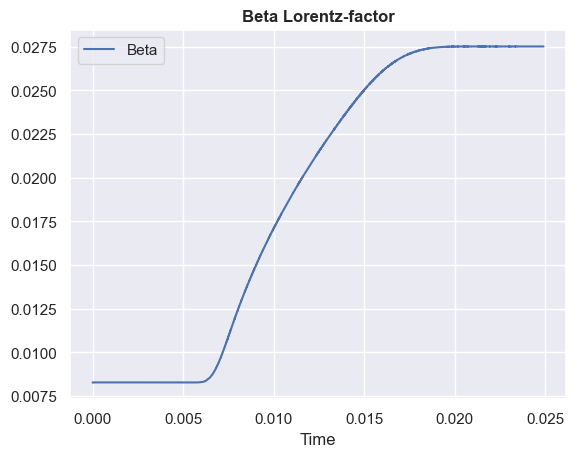

In [142]:
parameters_fct_rf[number][half_name].lorentz_factor_plot('Beta')

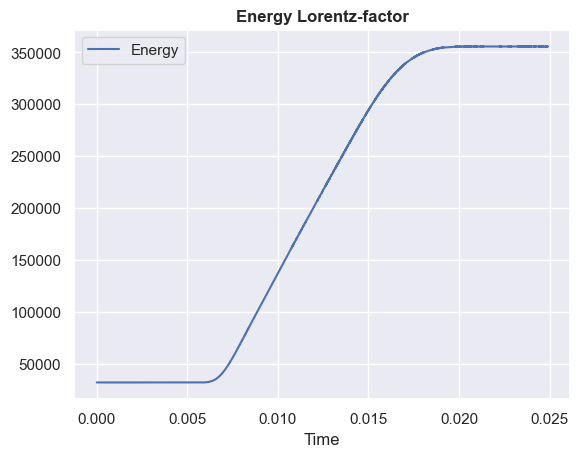

In [143]:
parameters_fct_rf[number][half_name].lorentz_factor_plot('Energy')

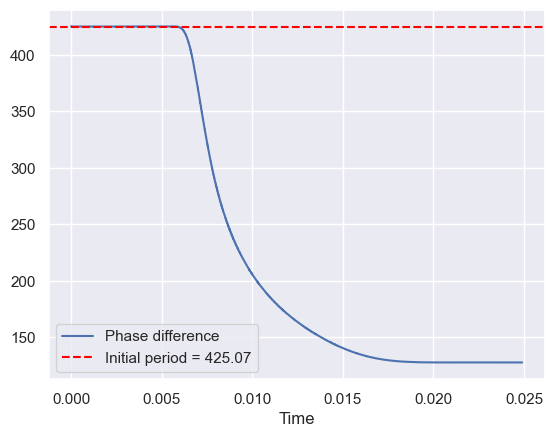

In [152]:
parameters_fct_rf[number][half_name].phase_difference_plot(period_line_plot_parameters={'color': 'red', 'linestyle': '--'})

# Обработка результатов

In [145]:
import pandas as pd

In [146]:
booster_acceleration_data = []
for p in parameters_fct_rf:
    dict_to_add = {}
    for key in half_names:
        # Зачем везде добавлять два нуля??
        dict_to_add[key] = pd.DataFrame(
            {'Phases': np.hstack(([0, 0], p[key].phases[phase_offset: -phase_offset])),
            'Intensities': np.hstack(([0, 0], p[key].intensities)),
            'Corrected phases': np.hstack(([0, 0], p[key].corrected_phases))})
    booster_acceleration_data.append(dict_to_add)

In [147]:
booster_acceleration_data[0]['first_half']

,Phases,Intensities,Corrected phases
0,0.000000e+00,0.000000e+00,0.000000
1,0.000000e+00,0.000000e+00,0.000000
2,8.177563e+02,2.190048e+07,-135.961250
3,1.242852e+03,2.198205e+07,-124.013794
4,1.667920e+03,2.121269e+07,-135.547226
...,...,...,...
124476,2.935915e+07,8.830344e+05,21.070979
124477,2.935927e+07,8.077415e+05,27.159535
124478,2.935940e+07,5.871716e+05,81.296862
124479,2.935953e+07,7.510889e+05,-55.829091


In [148]:
para

NameError: name 'para' is not defined

# Тесты

In [ ]:
import pandas as pd

with open('Acceleration in Booster measured with FCT/BoosterAcceleration1_1half.dat', "rb") as file:
    parameters_from_dan = [
        {'first_half': pd.DataFrame(np.load(file).reshape(-1,3), columns=['Phases', 'Intensities', 'Corrected phases'])}]

with open('Acceleration in Booster measured with FCT/BoosterAcceleration1_2half.dat', "rb") as file:
    parameters_from_dan[0]['second_half'] = pd.DataFrame(np.load(file).reshape(-1,3), columns=['Phases', 'Intensities', 'Corrected phases'])

with open('Acceleration in Booster measured with FCT/BoosterAcceleration2_1half.dat', "rb") as file:
    parameters_from_dan.append({'first_half': pd.DataFrame(np.load(file).reshape(-1,3), columns=['Phases', 'Intensities', 'Corrected phases'])})

with open('Acceleration in Booster measured with FCT/BoosterAcceleration2_2half.dat', "rb") as file:
    parameters_from_dan[1]['second_half'] = pd.DataFrame(np.load(file).reshape(-1,3), columns=['Phases', 'Intensities', 'Corrected phases'])

In [ ]:
parameters_from_file = []
for p in parameters_fct_rf:
    dict_to_add = {}
    for key in half_names:
        dict_to_add[key] = pd.DataFrame(
            {'Phases': p[key].phases[phase_offset: -phase_offset],
            'Intensities': p[key].intensities,
            'Corrected phases': p[key].corrected_phases})
    parameters_from_file.append(dict_to_add)

In [ ]:
for i in range(len(parameters_from_file)):
    for key in half_names:
        print(i, key)
        print(len(parameters_from_dan[i][key]), len(parameters_from_file[i][key]))
        print((parameters_from_dan[i][key] - parameters_from_file[i][key]).max(), '\n')


0 first_half
124479 124479
Phases              0.000000e+00
Intensities         2.458692e-07
Corrected phases    1.847411e-12
dtype: float64 

0 second_half
355508 355508
Phases              0.000000e+00
Intensities         1.229346e-07
Corrected phases    7.105427e-13
dtype: float64 

1 first_half
124476 124476
Phases              0.000000e+00
Intensities         2.607703e-07
Corrected phases    3.694822e-12
dtype: float64 

1 second_half
355502 355502
Phases              0.000000e+00
Intensities         1.192093e-07
Corrected phases    7.815970e-13
dtype: float64 

